# 3. External Data Ingestion from an Excel sheet

Let us follow a specific example of connecting data to an Omniverse prim by creating a live link between a Microsoft Excel sheet and the current USD stage.
We start with a simple example of 4 lightbulbs which have their coordinates and luminosity controlled via an external Excel sheet. You can use this concept to expand to adding custom data, such as temperature data to a lightbulb.

<div>
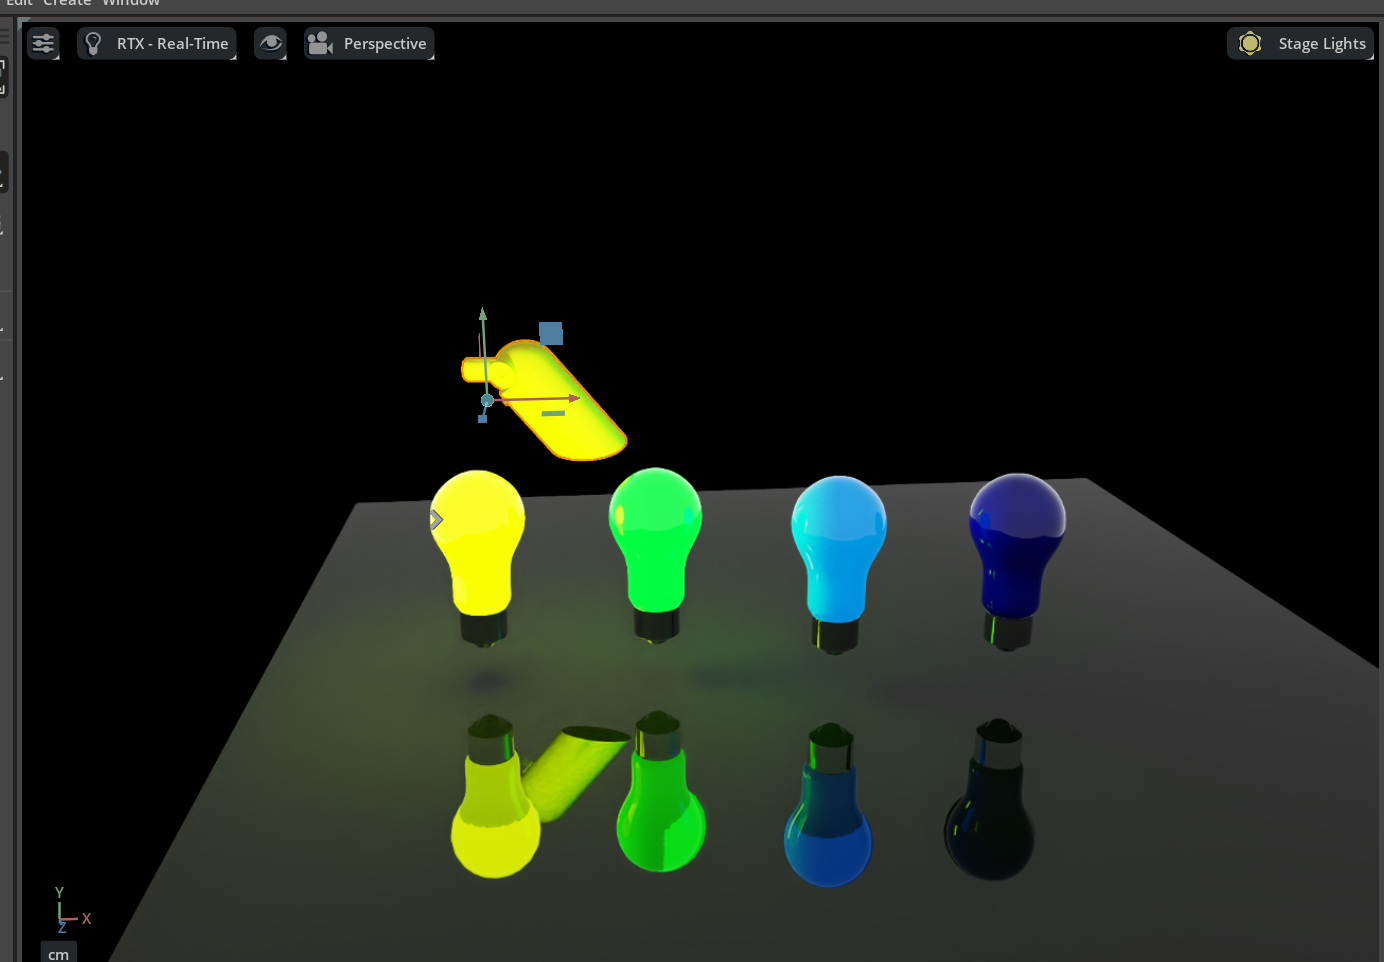
</div>

<div>
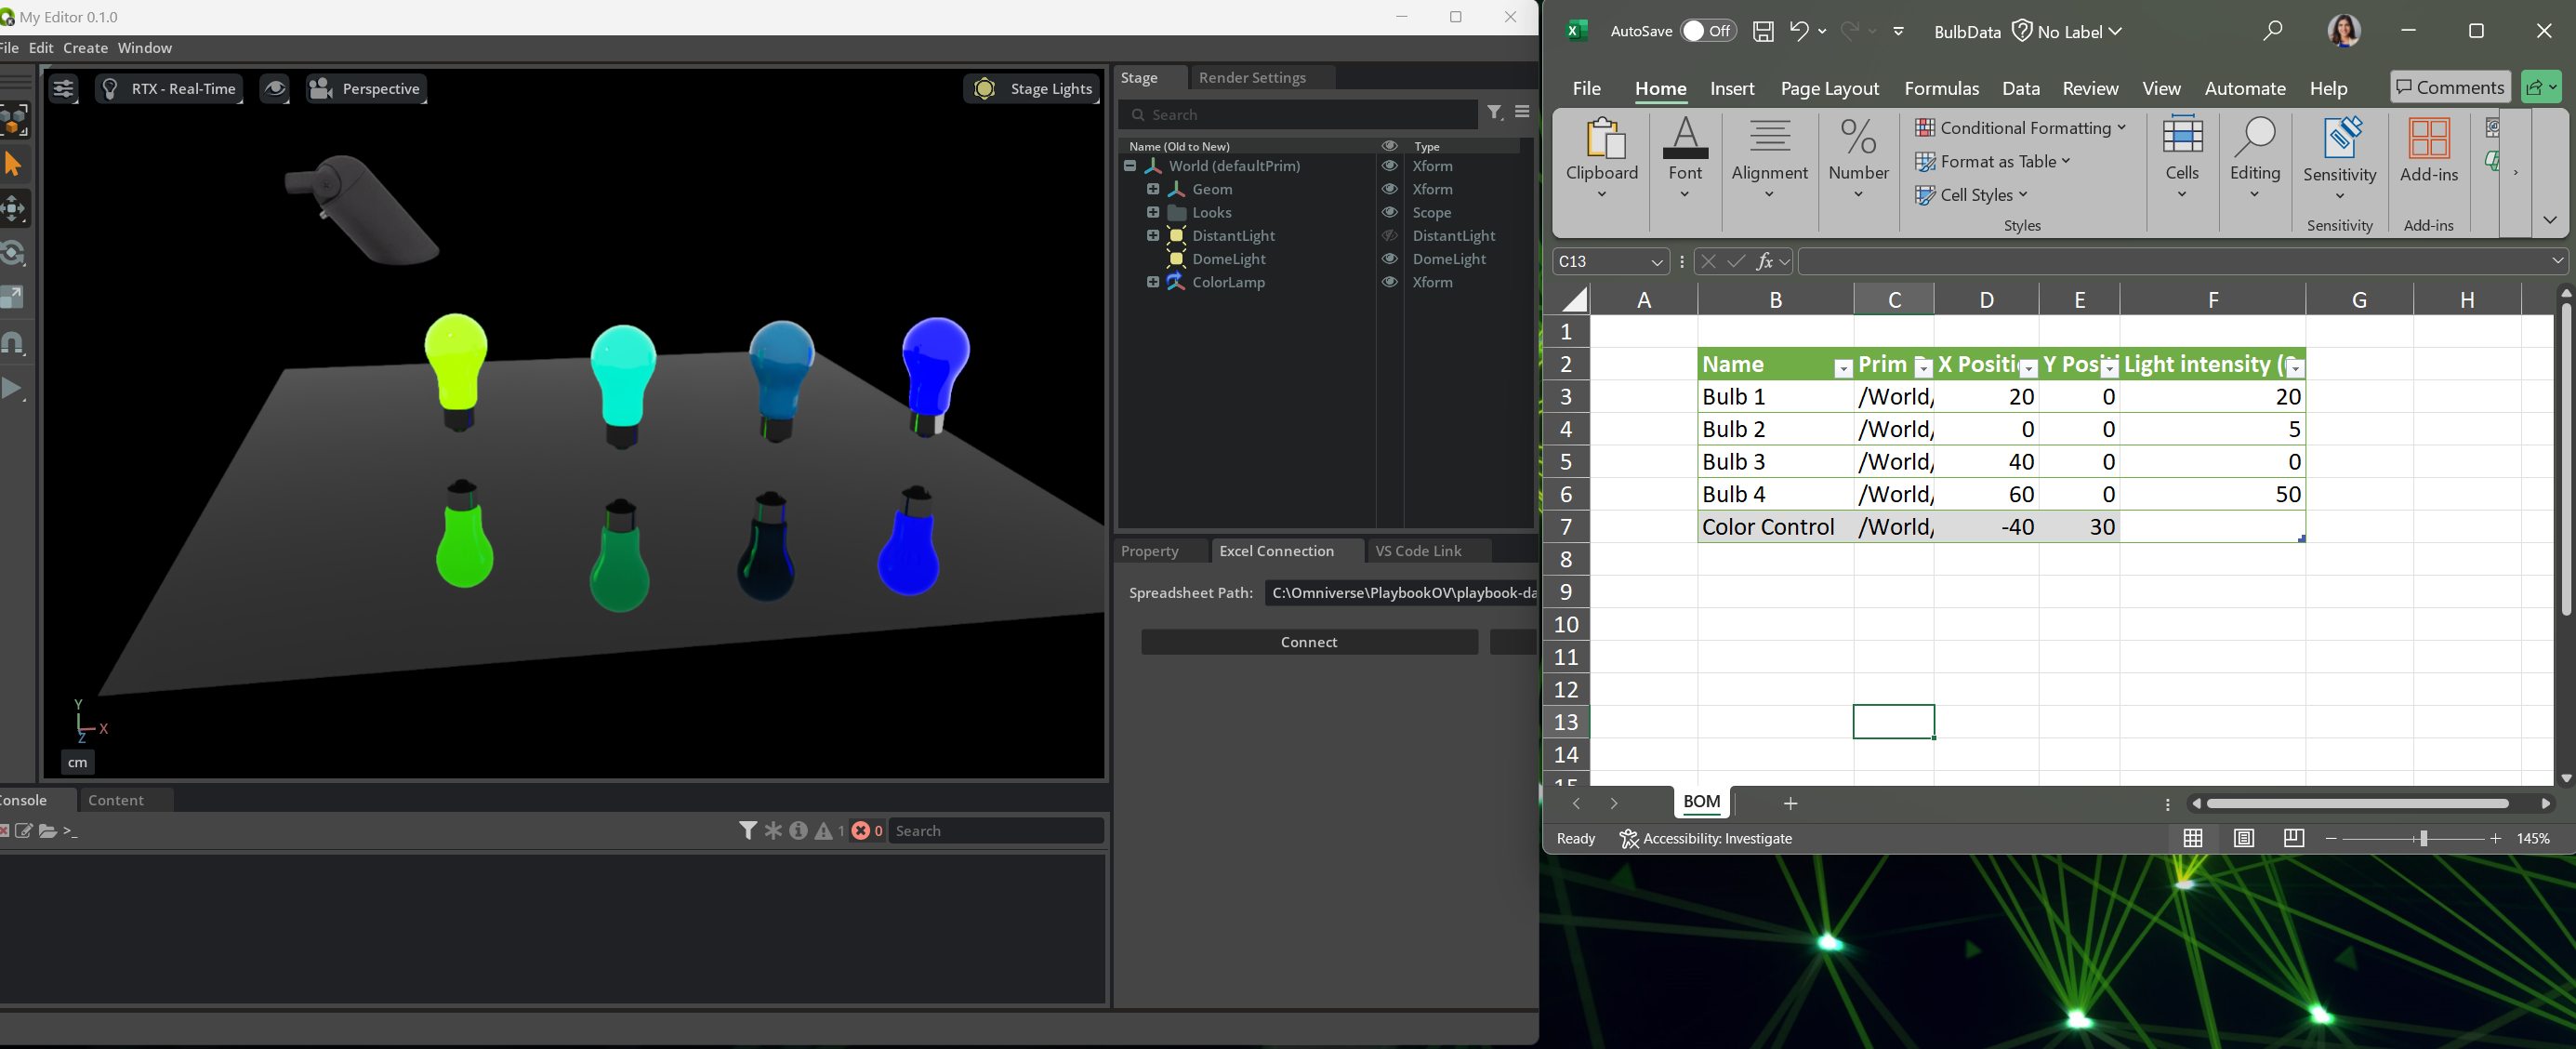
</div>



## Prerequisites
1. Cloned Kit App Template
2. Created a Kit Base Editor
3. Installed VSCode

### Step 1: Create an Extension
Kit Applications are a combination of multiple, custome developed, extensions. In this section, you create a base extension from the extension template. Later you will modify this extension to connect Excel to an OpenUSD scene.

#### Step 1.1: Open the Terminal
In VSCode open a new terminal window, if one is not already open.



#### Step 1.2: Create New Extension
In the terminal, run the template new command.


In [ ]:
.\repo.bat template new

Follow the prompt instructions, Use the arrow keys to move and Enter to select/continue:

? Select with arrow keys what you want to create: Extension
? Select with arrow keys your desired template:: Python UI Extension
? Enter name of extension [name-spaced, lowercase, alphanumeric]:: my.data_connect.ext
? Enter extension_display_name:: DT Data Connect
? Enter version:: 0.1.0


#### Step 1.3 Add the New Extension to the Application
In VSCode, go to source > apps > [YOUR KIT BASE EDITOR APP].kit, scroll to the [dependencies] section.

At the bottom of the [dependencies] section, add the following line:

<code> "my.data_connect.ext" = {} </code>

Save the .kit file.

#### Step 1.4: Run a Build
After a new extension has been added to the .kit file, the application should be rebuilt to ensure extensions are populated to the build directory.

In the terminal, run the build command.
<code>
.\repo.bat build
</code>


### Step 1.5: Launch the Application
In the terminal, run the launch command:



In [ ]:
.\repo.bat launch

? Select with arrow keys which App would you like to launch: [Select the desired editor application]

NOTE: The initial startup may take 5 to 8 minutes as shaders compile for the first time. After initial shader compilation, startup time will reduce dramatically

Upon launching your Application, a new window appears in your Application, called "DT Data Connect".

DO NOT close out of the Application.

### Step 2

Now we can get started with the actual extension code.

You will be working with your <code>extension.py</code> file in your newly generated extension; this is where you will be writing the bulk of the code.

To open <code>extension.py</code>:
* Navigate to the kit-app-template directory, and the directory as a project in VSCode.
* The <code>extension.py</code> file can be found under: .../kit-app-template/source/extensions/my.data_connect.ext/my/data_connect/ext/.
* Open the file in VSCode.
* Copy the path to your excel file (a sample has been provided in this notebook: samples/DTData.
* From here, replace the code in extension.py with the code below:

In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: LicenseRef-NvidiaProprietary
#
# NVIDIA CORPORATION, its affiliates and licensors retain all intellectual
# property and proprietary rights in and to this material, related
# documentation and any modifications thereto. Any use, reproduction,
# disclosure or distribution of this material and related documentation
# without an express license agreement from NVIDIA CORPORATION or
# its affiliates is strictly prohibited.
from pxr import Usd, UsdGeom
from pxr import Sdf, Gf, Vt
import omni.ext
import omni.ui as ui
from omni.kit.viewport.utility import get_active_viewport_window


from omni.ui import color as cl

import omni.usd
import re
import logging

# In order to work with com you will need to import pywin32
import omni.kit.pipapi
omni.kit.pipapi.install("pywin32")

# you also need to set the following environment variables to install pywin32
import os
import sys
import carb
from pathlib import Path
import pythonwin.pywin

dlls_path = Path(pythonwin.pywin.__file__).parent.parent.parent / "pywin32_system32"
com = Path(pythonwin.pywin.__file__).parent.parent.parent / "win32"
lib = Path(pythonwin.pywin.__file__).parent.parent.parent / "win32" / "lib"
pywin = Path(pythonwin.pywin.__file__).parent.parent.parent / "pythonwin"
carb.log_info(dlls_path)
sys.path.insert(0, str(com))
sys.path.insert(0, str(lib))
sys.path.insert(0, str(pywin))
carb.log_info(sys.path)
os.environ["PATH"] = f"{dlls_path};{os.environ['PATH']}"
carb.log_info(os.environ["PATH"])
# End of pywin32 installation.


# win32com.client lets you work with com libraries
import win32com.client

# This class mirrors the events in the com dll you would like to subscribe to
class WorksheetEvents:

    _excel_worksheet = None

    def OnChange(self, *args):

        # Check if the changed cell is within the specified range
        try:
            address_pattern = r'\$[DEF]\$[34567]'
            address = str(args[0].Address)
            if not re.match(address_pattern, address):
                return
        except Exception as e:
            carb.log_error('Could not detect cell changes' + e)

        # Get the prim path from Excel and update its position in the USD stage
        prim_path_cell_address = r"C" + address[3]
        prim_path = WorksheetEvents._excel_worksheet.Range(prim_path_cell_address).Value

        stage = omni.usd.get_context().get_stage()
        prim = stage.GetPrimAtPath(prim_path)

        if not prim.IsValid():
            carb.log_error("Can't find prim at path")
            return

        # move prim to new coordinates
        isBulbProp=False
        new_value = WorksheetEvents._excel_worksheet.Range(address).Value

        translate = prim.GetAttribute("xformOp:translate").Get()
        if (address[1] == "D"):
            translate[0] = new_value
        elif (address[1] == "E"):
            translate[1] = new_value

        # Update bulb light intensity or color based on changes in specific cells
        elif (address[1] == "F" and address[3] < "7"):
            order=int(address[3])-2
            bulb_shader_primpath = '/World/Looks/BulbLight'+str(order)
            bulb_shader_primpath = bulb_shader_primpath+'/Shader'
            bulb_shader_prim = stage.GetPrimAtPath(bulb_shader_primpath)
            lum_val=(new_value/100) * 100000
            light_intensity = bulb_shader_prim.GetAttribute('inputs:emissive_intensity')
            light_intensity.Set(lum_val)
            # **Update SphereLight attributes**
            sphere_light_path = f'/World/Geom/Bulb{order}/SphereLight'
            sphere_light_prim = stage.GetPrimAtPath(sphere_light_path)

            if sphere_light_prim.IsValid():
                sphere_intensity_attr = sphere_light_prim.GetAttribute('inputs:intensity')
                sphere_diffuse_attr = sphere_light_prim.GetAttribute('inputs:diffuse')

                # Calculate values based on new intensity
                sphere_intensity_value = (new_value / 100) * 50000
                sphere_diffuse_value = (new_value / 100) * 100

                sphere_intensity_attr.Set(sphere_intensity_value)
                sphere_diffuse_attr.Set(sphere_diffuse_value)

        if (address[3] == "7"):
            colorprim_path = '/World/ColorLamp'
            colorprim = stage.GetPrimAtPath(prim_path)
            color_new = WorksheetEvents._excel_worksheet.Range(address).Value
            colortranslate = colorprim.GetAttribute("xformOp:translate").Get()

            if address[1] == "D":
                colortranslate[0] = color_new
            elif address[1] == "E":
                colortranslate[1] = color_new

            # Set updated translation values back to the prim attributes
            colorprim.GetAttribute("xformOp:translate").Set(colortranslate)

        prim.GetAttribute("xformOp:translate").Set(translate)


# Define the main extension class to connect Excel with Omniverse scene elements

class OmniSampleExcel_connectionExtension(omni.ext.IExt):

    def __init__(self) -> None:
        super().__init__()


    # Handle startup actions for the extension including UI setup and event subscriptions

    def on_startup(self, ext_id):
        print("[omni.sample.excel_connection] omni sample excel_connection startup")

        self._window = ui.Window("Excel Connection", width=600, height=200)

        viewport_window = get_active_viewport_window()


        # Setup UI elements for file path input and connection buttons
        with self._window.frame:
            with ui.VStack():

                self._sheet_path = ui.SimpleStringModel(r"C:\Omniverse\PlaybookOV\playbook-data\BulbData.xlsx")
                with ui.HStack(style={"margin": 5}, height=40):
                    ui.Label("Spreadsheet Path:", width=50)
                    ui.StringField(self._sheet_path, width=500)

                with ui.HStack(style={"margin": 5}, height=40):
                    ui.Spacer()
                    ui.Button("Connect", clicked_fn=self.on_Connect_Click, width=300)
                    ui.Button("Disconnect", clicked_fn=self.on_Disconnect_Click, width=300)
                    ui.Spacer()

    # Function to handle connection to Excel and subscribing to changes in the scene and spreadsheet
    def on_Connect_Click(self):

        # Link to Excel
        self._excel_app = win32com.client.DispatchEx("excel.application")
        self._excel_app.Visible = True

        # Open workbook
        self._excel_workbook = self._excel_app.Workbooks.Open(self._sheet_path.as_string)

        try:
            if hasattr(self._excel_workbook, 'Worksheets'):
                self._excel_worksheet = self._excel_workbook.Worksheets(1)
            else:
                self._excel_worksheet = self._excel_workbook._dispobj_.Worksheets(1)
        except:
            carb.log_info("Could not find Worksheets attribute")
            return

        WorksheetEvents._excel_worksheet = self._excel_worksheet
        self._excel_events = win32com.client.WithEvents(self._excel_worksheet, WorksheetEvents)

        # Link to USD scene and set up watchers for changes in scene elements' attributes
        self._stage = omni.usd.get_context().get_stage()

        watcher = omni.usd.get_watcher()
        self.color_control_prim=self._stage.GetPrimAtPath('/World/ColorLamp')
        color_transl_attr = self.color_control_prim.GetAttribute("xformOp:translate")
        self.watcher_color = watcher.subscribe_to_change_info_path(color_transl_attr.GetPath(), self._color_changed)
        self.watcher_colortrans = watcher.subscribe_to_change_info_path(color_transl_attr.GetPath(), self._color_translate_changed)

        # Subscribe to changes for each prim defined in the spreadsheet and link them to scene updates

        self.prim_1 = self._stage.GetPrimAtPath(self._excel_worksheet.Range('C3').Value)
        if self.prim_1.IsValid():
            translate_attr = self.prim_1.GetAttribute("xformOp:translate")
            label_attr = self.prim_1.GetAttribute("LabelData").Get()
            self.watcher1 = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._translate_changed)
            self.watcher1c = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._color_changed)

        self.prim_2 = self._stage.GetPrimAtPath(self._excel_worksheet.Range('C4').Value)
        if self.prim_2.IsValid():
            translate_attr = self.prim_2.GetAttribute("xformOp:translate")
            label_attr = self.prim_2.GetAttribute('LabelData').Get()
            self.watcher2 = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._translate_changed)
            self.watcher2c = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._color_changed)

        self.prim_3 = self._stage.GetPrimAtPath(self._excel_worksheet.Range('C5').Value)
        if self.prim_3.IsValid():
            translate_attr = self.prim_3.GetAttribute("xformOp:translate")
            label_attr = self.prim_3.GetAttribute('LabelData').Get()
            self.watcher3 = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._translate_changed)
            self.watcher3c = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._color_changed)

        self.prim_4 = self._stage.GetPrimAtPath(self._excel_worksheet.Range('C6').Value)
        if self.prim_4.IsValid():
            translate_attr = self.prim_4.GetAttribute("xformOp:translate")
            label_attr = self.prim_4.GetAttribute('LabelData').Get()
            self.watcher4 = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._translate_changed)
            self.watcher4c = watcher.subscribe_to_change_info_path(translate_attr.GetPath(), self._color_changed)

    # Function to handle disconnection from Excel and clean up resources/subscriptions
    def on_Disconnect_Click(self):
        self._excel_events = None
        self._excel_worksheet = None

        if hasattr(self, '_excel_workbook'):
            if self._excel_workbook is not None:
                self._excel_workbook.Close(False)
                self._excel_workbook = None

        if hasattr(self, '_excel_app'):
            if self._excel_app is not None:
                self._excel_app.Application.Quit()
                self._excel_app = None

    # Handle changes in translation attributes from the scene and update Excel accordingly
    def _translate_changed(self, *args):
        # Check if the translation in excel is different
        translate_attribute = self._stage.GetAttributeAtPath(args[0])
        translate = translate_attribute.Get()
        prim_path = translate_attribute.GetPrimPath()
        prim = translate_attribute.GetPrim()
        label2_info=prim.GetAttribute('LabelData').Get()

        next_address = ""
        row = 3
        found = False
        sh = 1
        for row in range(3, 8):
            next_address = "C" + str(row)
            next_path = self._excel_worksheet.Range(next_address).Value
            if next_path == prim_path:
                found = True
                break

        if not found:
            carb.log_info("prim not found in excel worksheet")
            return

        x_address = "D" + str(row)
        excel_x = self._excel_worksheet.Range(x_address).Value

        y_address = "E" + str(row)
        excel_y = self._excel_worksheet.Range(y_address).Value

        sh = row - 2
        bulb_shader_primpath = '/World/Looks/BulbLight'+str(sh)
        bulb_shader_primpath = bulb_shader_primpath+'/Shader'
        bulb_shader_prim = self._stage.GetPrimAtPath(bulb_shader_primpath)

        intensity_addr = "F" + str(row)
        excel_intensity = self._excel_worksheet.Range(intensity_addr).Value
        lum_val=(excel_intensity/100) * 1000


        light_intensity = bulb_shader_prim.GetAttribute('inputs:emissive_intensity')
        light_intensity.Set(lum_val)

        # **Update SphereLight attributes when bulb moves**
        sphere_light_path = f'/World/Geom/Bulb{sh}/SphereLight'
        sphere_light_prim = self._stage.GetPrimAtPath(sphere_light_path)

        if sphere_light_prim.IsValid():
            # Calculate distance and color factor again for accurate updates
            color_translate = self.color_control_prim.GetAttribute("xformOp:translate").Get()
            distance = ((color_translate[0] - translate[0])**2 +
                        (color_translate[1] - translate[1])**2 +
                        (color_translate[2] - translate[2])**2)**0.5

            color_factor = max(0, min(1, 1 - (distance / 50)))  # Assuming max_distance is 50

            # Interpolate between blue, green, and red with emphasis on red
            if color_factor < 0.3:
                r, g, b = 0, color_factor * (1/0.3), 1 - color_factor * (1/0.3)
            elif color_factor < 0.6:
                r, g, b = (color_factor - 0.3) * (1/0.3), 1, 0
            else:
                r, g, b = 1, 1 - (color_factor - 0.6) * (5/0.4), 0

            emissive_color = Gf.Vec3f(min(r * 1.5, 1.0), min(g * 1.5, 1.0), min(b * 1.5, 1.0))
            sphere_intensity_value = color_factor * 50000
            sphere_diffuse_value = color_factor * 100

            sphere_intensity_attr = sphere_light_prim.GetAttribute('inputs:intensity')
            sphere_diffuse_attr = sphere_light_prim.GetAttribute('inputs:diffuse')
            sphere_color_attr = sphere_light_prim.GetAttribute('inputs:color')

            sphere_intensity_attr.Set(sphere_intensity_value)
            sphere_diffuse_attr.Set(sphere_diffuse_value)
            sphere_color_attr.Set(emissive_color)


        # No change in value
        if excel_x == translate[0] and excel_y == translate[1]:
            carb.log_info("no change in value")
            return

        # If so change it.
        self._excel_worksheet.Range(x_address).Value = translate[0]
        self._excel_worksheet.Range(y_address).Value = translate[1]

    # Handle changes in color attributes from the scene
    def _color_changed(self, *args):
        changed_attribute = self._stage.GetAttributeAtPath(args[0])
        changed_prim = changed_attribute.GetPrim()

        # Determine if the change is from the color control prim or a bulb
        is_color_control = (changed_prim == self.color_control_prim)

        color_translate = self.color_control_prim.GetAttribute("xformOp:translate").Get()
        max_distance = 50  # Adjust this value based on your scene scale

        prims_to_update = [self.prim_1, self.prim_2, self.prim_3, self.prim_4] if is_color_control else [changed_prim]

        for prim in prims_to_update:
            if prim.IsValid():
                translate = prim.GetAttribute("xformOp:translate").Get()

                distance = ((color_translate[0] - translate[0])**2 +
                            (color_translate[1] - translate[1])**2 +
                            (color_translate[2] - translate[2])**2)**0.5

                # **Calculate color factor**
                color_factor = max(0, min(1, 1 - (distance / max_distance)))

                # **Interpolate between blue, green, and red**
                if color_factor < 0.3:
                    # Blue to Green
                    r = 0
                    g = color_factor * (1/0.3)
                    b = 1 - color_factor * (1/0.3)
                elif color_factor < 0.6:
                    # Green to Yellow
                    r = (color_factor - 0.3) * (1/0.3)
                    g = 1
                    b = 0
                else:
                    # Yellow to Red quickly
                    r = 1
                    g = 1 - (color_factor - 0.6) * (5/0.4)  # Faster transition to red
                    b = 0

                # **Create diffuse tint and emissive color**
                diffuse_tint = Gf.Vec3f(r * 0.5, g * 0.5, b * 0.5)
                emissive_color = Gf.Vec3f(min(r * 1.5, 1.0), min(g * 1.5, 1.0), min(b * 1.5, 1.0))

                # Update emissive intensity based on color factor
                emissive_intensity_value = color_factor * 50000

                # **Calculate SphereLight intensity and diffuse**
                sphere_intensity_value = color_factor * 50000
                sphere_diffuse_value = color_factor * 100

                # Update the color of the bulb
                bulb_order = next(i for i, p in enumerate([self.prim_1, self.prim_2, self.prim_3, self.prim_4], 1) if p == prim)
                bulb_shader_primpath = f'/World/Looks/BulbLight{bulb_order}/Shader'
                bulb_shader_prim = self._stage.GetPrimAtPath(bulb_shader_primpath)

                sphere_light_path = f'/World/Geom/Bulb{bulb_order}/SphereLight'
                sphere_light_prim = self._stage.GetPrimAtPath(sphere_light_path)

                if bulb_shader_prim.IsValid():
                    color_attr = bulb_shader_prim.GetAttribute('inputs:diffuse_tint')
                    emissive_color_attr = bulb_shader_prim.GetAttribute('inputs:emissive_color')
                    emissive_intensity_attr = bulb_shader_prim.GetAttribute('inputs:emissive_intensity')

                    color_attr.Set(diffuse_tint)
                    emissive_color_attr.Set(emissive_color)
                    emissive_intensity_attr.Set(emissive_intensity_value)

                    excel_row = str(bulb_order + 2)  # Assuming rows start at C3 for bulbs
                    luminosity_cell_address = f"F{excel_row}"

                    # Update Excel with new luminosity value derived from emissive intensity
                    self._excel_worksheet.Range(luminosity_cell_address).Value = emissive_intensity_value / 1000

                # **Update SphereLight attributes**
                if sphere_light_prim.IsValid():
                    sphere_intensity_attr = sphere_light_prim.GetAttribute('inputs:intensity')
                    sphere_diffuse_attr = sphere_light_prim.GetAttribute('inputs:diffuse')
                    sphere_color_attr = sphere_light_prim.GetAttribute('inputs:color') # New line for SphereLight color

                    sphere_intensity_attr.Set(sphere_intensity_value)
                    sphere_diffuse_attr.Set(sphere_diffuse_value)
                    sphere_color_attr.Set(emissive_color) # Set SphereLight's inputs:color to match emissive color



    # Handle changes in translation of color control element
    def _color_translate_changed(self, *args):
        translate_attribute = self._stage.GetAttributeAtPath(args[0])
        translate = translate_attribute.Get()

        # Update Excel with new transform values
        self._excel_worksheet.Range('D7').Value = translate[0]
        self._excel_worksheet.Range('E7').Value = translate[1]



    # Clean up resources when shutting down the extension
    def on_shutdown(self):
        # Step 10
        self._excel_events = None
        self._excel_worksheet = None

        if hasattr(self, '_excel_workbook'):
            if self._excel_workbook is not None:
                self._excel_workbook.Close(False)
                self._excel_workbook = None

        if hasattr(self, '_excel_app'):
            if self._excel_app is not None:
                self._excel_app.Application.Quit()
                self._excel_app = None


Saving the file at this point should launch the extension and let you use the completed extension.
### Notes:
This code establishes a bidirectional connection between a 3D scene in NVIDIA's Omniverse platform and an external data source (an Excel spreadsheet). The connection allows real-time updates between spreadsheet data and 3D objects within Omniverse. The code facilitates creating a simplistic digital twin by linking non-3D data (Excel) with 3D data (Omniverse), allowing dynamic updates based on user interactions or data changes. Changes in specified cells of an Excel sheet influence corresponding 3D objects' properties such as position or light intensity.

#### Functions
* `WorksheetEvents` Class: Handles events triggered by changes in an Excel worksheet. It monitors specific cells and updates corresponding 3D object attributes like position or intensity.
OmniSampleExcel_connectionExtension Class: Main extension class that manages connection setup between Excel and Omniverse.
* __init__: Initializes the extension.
* on_startup: Sets up UI elements and prepares event subscriptions.
* on_Connect_Click: Establishes a connection with Excel, opens a workbook, sets up event handlers for worksheet changes, and subscribes to USD stage changes.
* on_Disconnect_Click: Disconnects from Excel and cleans up resources.
* _translate_changed: Updates Excel when translations of 3D objects change.
* _color_changed: Responds to changes in color attributes within the scene.
* _color_translate_changed: Manages updates when the translation of a color control element changes.
* on_shutdown: Cleans up resources upon extension shutdown.


### Testing the extension
* Open the sample USD file provided, samples/bulb_color_sample.usd
* Expand the prims
* In the newly opened extension window, change your spreadsheet path to point to BulbData.xls
* Click Connect.
* This opens up an Excel window with the spreadsheet containing information about the prims on the stage.
* You should be able to modify values in the excel sheet and see them reflected on the prims
* To modify the prims, select any of the Bulb-x prims and move them around to see how they react to the color lamp's proximity.
* Alternatively you can also move the color lamp around to influence the color of the bulbs
* Individual bulb luminosity can be configured in the spreadsheet.
* Bonus: try to add labels above the bulbs to reflect the data in the spreadsheet.